### パッケージのインポート

In [74]:
import os
import random
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
# from swan import pycwt

### データの確認

In [2]:
# ディレクトリ下に存在するファイル名の取得
def get_file_data(dir_path) -> list:
    filenames = sorted(os.listdir(dir_path))
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
    return filenames


# 欠損値数と最大値をとる時刻の確認
def null_max_cnt(filename_path, df_list):
    null_list = []
    max_list = []

    for i in range(len(df_list)):
        df = pd.read_csv(filename_path+df_list[i], index_col=0)
        null_list += [[df_list[i], df[["observed", "astoro", "deviation"]].isnull().any(axis=1).sum()]]
        max_list += [
            [df_list[i], df.loc[df["observed"].idxmax(), "datetime"]]
        ]

    return null_list, max_list

In [3]:
# 使用するリストの定義
filename_path = "../data/tsunami/NOWPHAS_Tsunami_data/csv/cut_csv/"
df_list = get_file_data(filename_path)
null_list, max_list = null_max_cnt(filename_path, df_list)

In [4]:
# 欠損値数を調べる
null_df = pd.DataFrame(null_list, columns=["filename", "null_num"])
null_df = null_df.sort_values(by=["null_num"], ascending=False)

null_df[null_df["null_num"] > 0]

,filename,null_num
7,cut_2011TET219W.csv,1095
6,cut_2011TET219T.csv,1017
3,cut_2011TET203W.csv,875
4,cut_2011TET205W.csv,834
2,cut_2011TET203T.csv,121
39,cut_2011TET812G.csv,7


In [5]:
# 各地点の水位が最大値をとる時刻を調べる
max_df = pd.DataFrame(max_list, columns=["filename", "datetime"])
max_df = max_df.sort_values(by="datetime")

max_df.head(10)

,filename,datetime
17,cut_2011TET319T.csv,2011-03-11 15:00:00
15,cut_2011TET317T.csv,2011-03-11 15:00:00
16,cut_2011TET318T.csv,2011-03-11 15:01:25
13,cut_2011TET315T.csv,2011-03-11 15:01:40
33,cut_2011TET802G.csv,2011-03-11 15:11:35
35,cut_2011TET804G.csv,2011-03-11 15:12:00
34,cut_2011TET803G.csv,2011-03-11 15:14:00
36,cut_2011TET806G.csv,2011-03-11 15:15:35
32,cut_2011TET801G.csv,2011-03-11 15:16:00
37,cut_2011TET807G.csv,2011-03-11 15:19:20


/var/folders/yy/h4ndzppd11l1g6sl_d1_jymw0000gq/T/ipykernel_5610/548467460.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


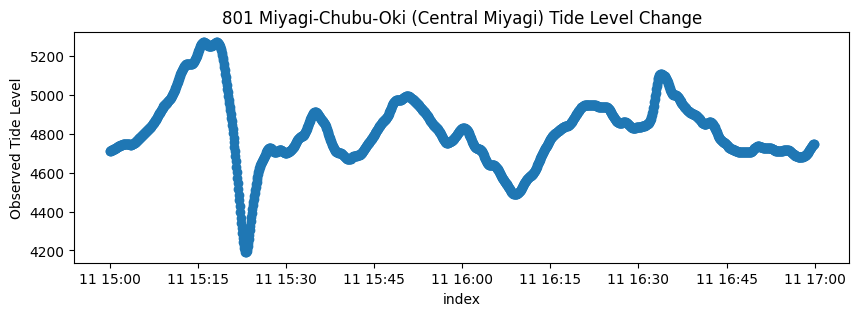

In [6]:
# 801Gの実測水位データの可視化
fig = plt.figure(figsize=(10,3))

cut_test_df = pd.read_csv(filename_path+"cut_2011TET801G.csv", index_col=0)
for i in range(len(cut_test_df)):
    s = cut_test_df.loc[i, "datetime"]
    cut_test_df.loc[i, "datetime"] = dt.strptime(s, "%Y-%m-%d %H:%M:%S")

plt.scatter(x=cut_test_df["datetime"], y=cut_test_df["observed"])
plt.title("801 Miyagi-Chubu-Oki (Central Miyagi) Tide Level Change")
plt.xlabel("index")
plt.ylabel("Observed Tide Level")

fig.show()

#### 欠損値補完

In [7]:
# 欠損値補完
def completion(df:pd.DataFrame, nan_num, seed_val):
    random.seed(seed_val)
    nan_index = sorted(random.sample(range(1, len(df)-1), nan_num))

    nan_full_df = df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    filled_df = nan_full_df.copy()

    for i in range(nan_num):
        if i != nan_num-1 and nan_index[i]+1 == nan_index[i+1]:
            filled_df.loc[nan_index[i], "observed"] = filled_df.loc[nan_index[i]-1, "observed"]
        else:
            filled_df.loc[nan_index[i], "observed"] = (filled_df.loc[nan_index[i]+1, "observed"]+
                                                    filled_df.loc[nan_index[i]-1, "observed"])/2

    return nan_full_df, filled_df, nan_index


# 補完したデータフレームを作成
def df_completion(pre_df: pd.DataFrame) -> pd.DataFrame:
    nan_index = []
    for i in range(len(pre_df)):
        if pre_df.loc[i].hasnans:
            nan_index.append(i)

    nan_full_df = pre_df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    cmp_test_df = nan_full_df.copy()

    for i in range(len(nan_index)):
        if i == len(nan_index)-1 or nan_index[i]+1 == nan_index[i+1]:
            cmp_test_df.loc[nan_index[i], "observed"] = cmp_test_df.loc[nan_index[i]-1, "observed"]

        else:
            cmp_test_df.loc[nan_index[i], "observed"] = (cmp_test_df.loc[nan_index[i]+1, "observed"]+
                                                    cmp_test_df.loc[nan_index[i]-1, "observed"])/2

    # 合わせて潮位偏差も補完
    for i in range(len(cmp_test_df)):
        cmp_test_df.loc[i, "deviation"] = cmp_test_df.loc[i, "observed"] - cmp_test_df.loc[i, "astoro"]

    return cmp_test_df


In [8]:
# ランダムに発生させた欠損値に対して補完
full_df = cut_test_df.reset_index().drop("index", axis=1)
nan_test_df, completion_test_df, nan_index = completion(full_df, 3, seed_val=42)

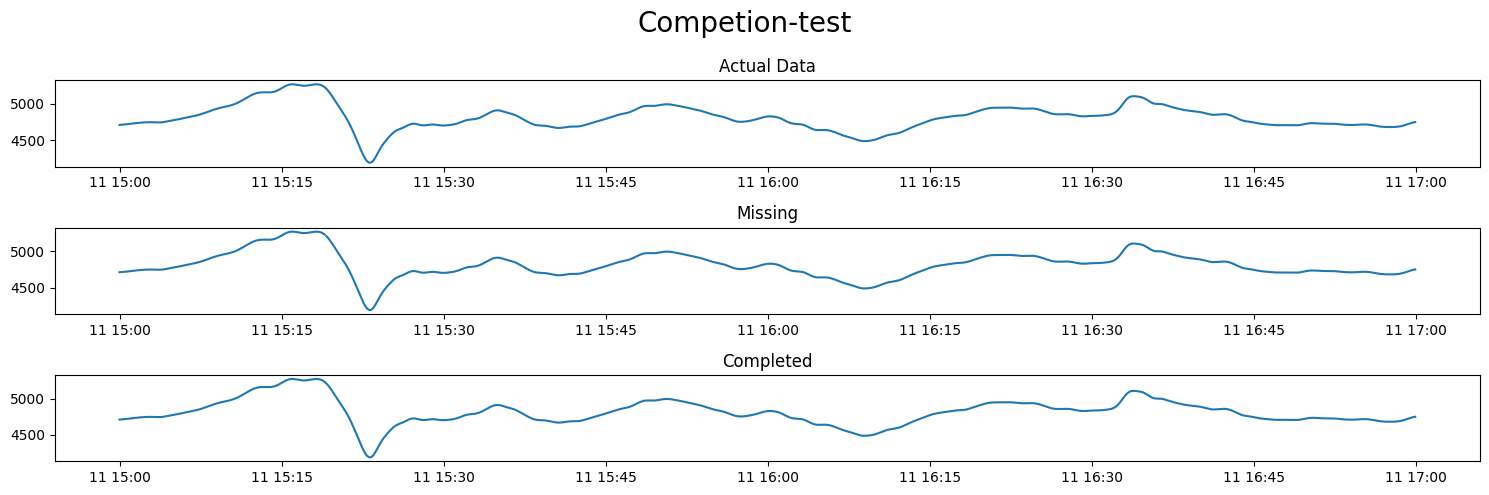

52      2011-03-11 15:04:20
229     2011-03-11 15:19:05
1310    2011-03-11 16:49:10
Name: datetime, dtype: object

In [9]:
# 補完前後のグラフを表示
fig, ax = plt.subplots(3,figsize=(15,5))

ax[0].plot(full_df["datetime"], full_df["observed"])
ax[0].set_title("Actual Data")

ax[1].plot(nan_test_df["datetime"], nan_test_df["observed"])
ax[1].set_title("Missing")

ax[2].plot(completion_test_df["datetime"], completion_test_df["observed"])
ax[2].set_title("Completed")

plt.suptitle("Competion-test", fontsize=20)
plt.tight_layout()
plt.show()

full_df.loc[nan_index, "datetime"]

In [10]:
# 補完方法の評価
num = 100
runs = 10**3

error = 0
for i in range(runs):
    nan_full_df, filled_df, nan_index = completion(full_df, num, seed_val=i)
    for idx in nan_index:
        error += abs(full_df.loc[idx, "observed"] - filled_df.loc[idx, "observed"])

# 平均絶対誤差に変換して出力
print(f"平均絶対誤差 :\n\terror : {error / (num * runs)}")

平均絶対誤差 :
	error : 0.54435149999998


誤差は小さなものであるから,この方法を用いて,各データに対し補完を行う.

In [11]:
# 全水位データを補完データで置き換える
cmp_filename_path = "../data/tsunami/NOWPHAS_Tsunami_data/csv/cmp_csv/"

for file in df_list:
    df = pd.read_csv(filename_path+file, index_col=0)
    df = df_completion(df)
    df.to_csv(cmp_filename_path+file)

### データフレームの作成

In [12]:
# メインデータフレームの作成
main_df = cut_test_df
main_df = main_df.drop(["index", "deviation"], axis=1)

# 差分データと過去1分間の水位データを結合
main_df["observed_diff"] = None
for i in range(len(main_df)-1):   
    main_df.loc[i, "observed_diff"] = main_df.loc[i+1, "observed"] - main_df.loc[i, "observed"]

main_df_times = [f"observed_{5*i}s" for i in range(1, 13)]
for i in range(len(main_df_times)):
    main_df[main_df_times[i]] = main_df["observed"].shift(-i-1)

In [13]:
# 801Gより先に津波が到達した地点の,5秒前の水位データを結合
cmp_filenames = ["2011TET318T.csv", "2011TET317T.csv",
                 "2011TET315T.csv", "2011TET319T.csv",
                 "2011TET802G.csv", "2011TET804G.csv",
                 "2011TET803G.csv", "2011TET806G.csv"]

pre_list = []
pre_columns = []
for filename in cmp_filenames:
    pre_df = pd.read_csv(filename_path+file, index_col=0)
    pre_list.append(pre_df["observed"].shift(1))
    pre_columns.append(f"observed+{filename[7:11]}")

for i in range(len(pre_columns)):
    main_df[pre_columns[i]] = pre_list[i]

main_df = main_df.drop("datetime", axis=1)
main_df

,observed,astoro,observed_diff,observed_5s,observed_10s,observed_15s,observed_20s,observed_25s,observed_30s,observed_35s,...,observed_55s,observed_60s,observed+318T,observed+317T,observed+315T,observed+319T,observed+802G,observed+804G,observed+803G,observed+806G
0,4711.34,4690.69,1.05,4712.39,4713.71,4714.63,4715.89,4717.22,4718.21,4719.74,...,4725.31,4726.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4712.39,4690.71,1.32,4713.71,4714.63,4715.89,4717.22,4718.21,4719.74,4720.88,...,4726.83,4728.27,-54.32,-54.32,-54.32,-54.32,-54.32,-54.32,-54.32,-54.32
2,4713.71,4690.73,0.92,4714.63,4715.89,4717.22,4718.21,4719.74,4720.88,4722.42,...,4728.27,4729.88,-54.34,-54.34,-54.34,-54.34,-54.34,-54.34,-54.34,-54.34
3,4714.63,4690.74,1.26,4715.89,4717.22,4718.21,4719.74,4720.88,4722.42,4723.77,...,4729.88,4731.36,-54.33,-54.33,-54.33,-54.33,-54.33,-54.33,-54.33,-54.33
4,4715.89,4690.76,1.33,4717.22,4718.21,4719.74,4720.88,4722.42,4723.77,4725.31,...,4731.36,4732.83,-54.30,-54.30,-54.30,-54.30,-54.30,-54.30,-54.30,-54.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,4740.25,4721.28,2.88,4743.13,4745.78,4747.96,4750.03,NaN,NaN,NaN,...,NaN,NaN,55.55,55.55,55.55,55.55,55.55,55.55,55.55,55.55
1436,4743.13,4721.30,2.65,4745.78,4747.96,4750.03,NaN,NaN,NaN,NaN,...,NaN,NaN,55.54,55.54,55.54,55.54,55.54,55.54,55.54,55.54
1437,4745.78,4721.32,2.18,4747.96,4750.03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,55.55,55.55,55.55,55.55,55.55,55.55,55.55,55.55
1438,4747.96,4721.34,2.07,4750.03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,55.57,55.57,55.57,55.57,55.57,55.57,55.57,55.57


### 重回帰分析

In [14]:
# 重回帰分析を行う
def train_predict(X, y, split_rate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=316)
    regressor = LinearRegression().fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)
    for i in range(len(y_pred)):
        y_pred[i] = round(y_pred[i])
    
    train_mse = np.mean((y_train_pred - y_train) ** 2)
    test_mse = np.mean((y_pred - y_test) ** 2)
    print("MSE train data: ", train_mse)
    print("MSE test data: ", test_mse)

    out = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_train_pred": y_train_pred
    }

    return regressor, out

In [15]:
# 説明変数データに欠損値を含むものを削除
drop_list = ["observed_diff"]
drop_list += [f"observed_{5*i}s" for i in range(1, 13)]
drop_list += [f"observed+{filename[7:11]}" for filename in cmp_filenames]
main_df = main_df.dropna(subset=drop_list)

# 重回帰分析を実行
drop_list.remove("observed_diff")
X = main_df[drop_list+["astoro"]]
y = main_df["observed_diff"]
regressor, out = train_predict(X, y, 0.30)

MSE train data:  0.03498879103300001
MSE test data:  0.12724498834500794


In [16]:
# 決定係数の算出
print("r^2 train data: ", r2_score(out["y_train"], out["y_train_pred"]))
print("r^2 test data: ", r2_score(out["y_test"], out["y_pred"]))

r^2 train data:  0.9989318273641382
r^2 test data:  0.9962986463399607


テストデータを用いた場合の方が,誤差がより大きく,決定係数がより小さい.このことから,過学習が起きていると考えられる.

#### 評価

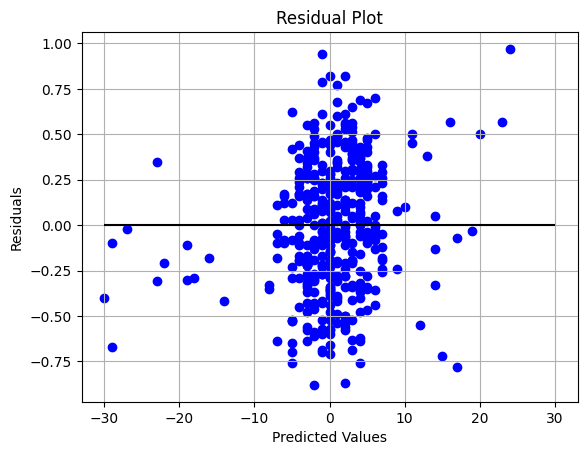

In [17]:
plt.scatter(out["y_pred"], out["y_pred"] - out["y_test"], color = "blue")
plt.hlines(y = 0, xmin = -30, xmax = 30, color="black")
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()

### 主成分分析による次元圧縮

In [18]:
def pca_result(pipeline, X_train, y_train, X_test, y_test):
    # 精度の算出
    print('train score: {:.3f}'.format(pipeline.score(X_train, y_train)))
    print('test score: {:.3f}'.format(pipeline.score(X_test, y_test)))
    print("\n")

    # 平均二乗誤差の算出
    train_mse = np.mean((pipeline.predict(X_train) - y_train) ** 2)
    test_mse = np.mean((pipeline.predict(X_test) - y_test) ** 2)
    print("MSE train data: ", train_mse)
    print("MSE test data: ", test_mse)
    print("\n")

    # 決定係数の算出
    print("r^2 train data: ", r2_score(y_train, pipeline.predict(X_train)))
    print("r^2 test data: ", r2_score(y_test, pipeline.predict(X_test)))

In [98]:
# 標準化および次元圧縮、重回帰分析を行う
pca_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("decomposition", PCA(n_components=14)),
    ("model", LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=316)
pca_pipeline.fit(X_train, y_train)

pca_result(pca_pipeline, X_train, y_train, X_test, y_test)

train score: 0.999
test score: 0.999


MSE train data:  0.03498879103298874
MSE test data:  0.040428638424096136


r^2 train data:  0.9989318273641385
r^2 test data:  0.998823995422156


10次元に圧縮したところ,MSEと決定係数は共に,差が先ほどよりも縮まった.

#### 最適なパラメータの算出

In [97]:
# 平均二乗誤差を用いて,最適なn_neighborsを探す
score_list = []
n_list = np.arange(1, 22)

for n in n_list:
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    pca_model = Pipeline([
    ("scale", StandardScaler()),
    ("decomposition", PCA(n_components=n)),
    ("model", LinearRegression())
    ])

    scores = cross_val_score(pca_model, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
    score_list.append(-np.mean(scores))
print(f"best n_components: {n_list[np.argmin(score_list)]}")

best n_components: 14


これより,引数としてn_components=14を採用する.

### ノンパラメトリック回帰

#### 季節成分の確認

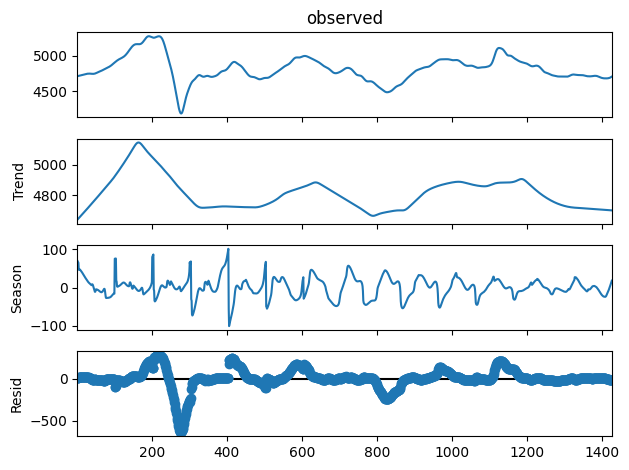

In [20]:
# STL分解
stl = STL(main_df.observed, period=100, robust=True).fit()
stl.plot()
plt.show()

グラフから,季節成分が存在することがわかる.また,これは波の周期によるものであると予想できる.

#### ノンパラメトリック回帰の実行

In [99]:
# 標準化および次元圧縮、kNN回帰分析を行う
knn_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("decomposition", PCA(n_components=14)),
    ("model", KNeighborsRegressor(n_neighbors=2))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=316)
knn_pipeline.fit(X_train, y_train)

pca_result(knn_pipeline, X_train, y_train, X_test, y_test)

train score: 0.997
test score: 0.989


MSE train data:  0.09078101202403843
MSE test data:  0.3766416666667092


r^2 train data:  0.9972285469135399
r^2 test data:  0.9890440949417963


#### 最適なパラメータの算出

In [95]:
# 平均二乗誤差を用いて,最適なn_neighborsを探す
score_list = []
k_list = np.arange(1, 30)

for k in k_list:
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    knn_model = Pipeline([
    ("scale", StandardScaler()),
    ("decomposition", PCA(n_components=10)),
    ("model", KNeighborsRegressor(n_neighbors=k))
    ])

    scores = cross_val_score(knn_model, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
    score_list.append(-np.mean(scores))
print(f"best n_neighbors: {k_list[np.argmin(score_list)]}")

best n_neighbors: 2


これより,kNN回帰分析における引数としてn_neighbors=2を採用する.

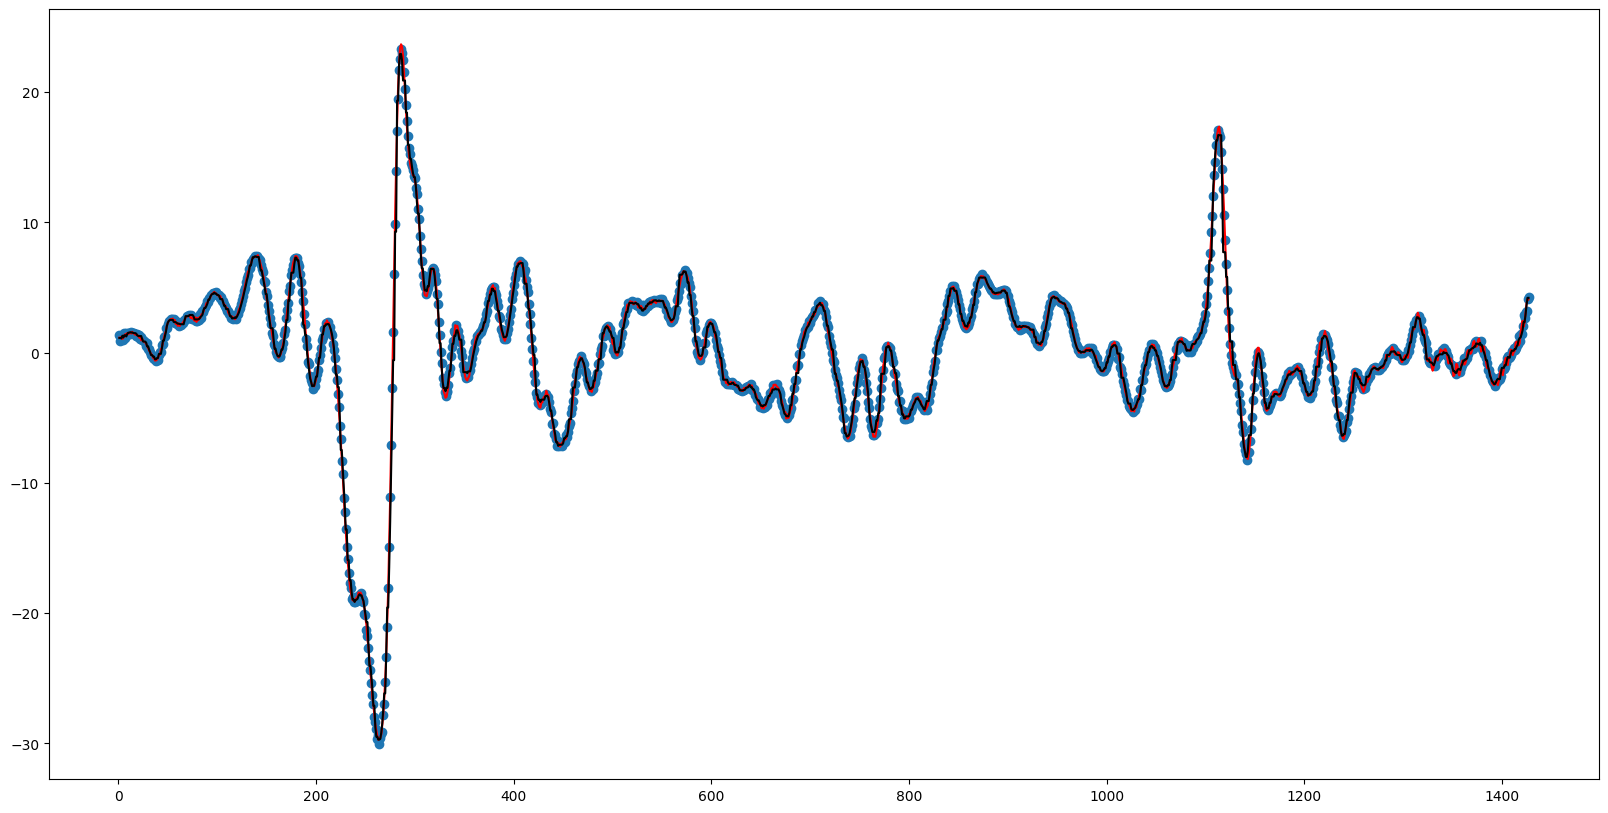

In [96]:
# 可視化
fig = plt.figure(figsize=(20,10))

plt.scatter(X.index, y)
plt.plot(X.index, pca_pipeline.predict(X), color="red")
plt.plot(X.index, knn_pipeline.predict(X), color="black")

plt.show()